In [1]:
import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)


# Analyse comparative des quantités de points d'arrêts

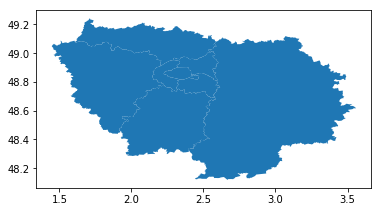

In [2]:
#contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
zones.plot()

In [3]:
#on charge les données
osm_stoppoints = pd.read_csv("../data/osm-transit-extractor_stop_points.csv", dtype=str)
gtfs_stoppoints = pd.read_csv("../data/gtfs_stops.txt", dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]
zones_with_stoppoints_count = zones_with_stoppoints_count.sort_values("name").reset_index().drop("index", axis=1)
zones_with_stoppoints_count


,name,geometry,nb_stoppoints_officiel,nb_stoppoints_osm,couverture_stoppoints_osm
0,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",5919,3679,62.155770
1,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3740,2772,74.117647
2,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",3054,2405,78.749181
3,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",4032,2596,64.384921
4,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",8299,4609,55.536812
5,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",4765,2981,62.560336
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3158,2690,85.180494
7,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",8332,3972,47.671627


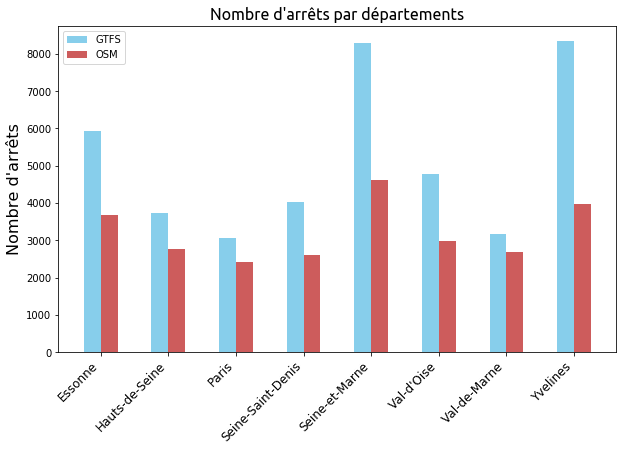

In [4]:
#histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind - width/2, zones_with_stoppoints_count["nb_stoppoints_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_stoppoints_count["nb_stoppoints_osm"], 
                width, color='IndianRed', label='OSM')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Nombre d\'arrêts par départements', 
             fontname='Ubuntu', fontsize=16,
             fontstyle='normal', fontweight='normal')
ax.set_ylabel('Nombre d\'arrêts', fontsize=16)

ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()


In [5]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_stoppoints_count, data=zones_with_stoppoints_count, columns=['name', 'couverture_stoppoints_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [6]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

61.70958220345084

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

# Analyse comparative en utilisant les lignes desservies

In [7]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv("../data/gtfs_routes.txt", dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv("../data/osm-transit-extractor_lines.csv", dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [8]:
len(osm_lines) * 100.0 / len(gtfs_lines)

49.69461410327596

In [9]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv("../data/opendata_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
#gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [10]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

zones_with_routepoints_count.sort_values("name", inplace=True)
zones_with_routepoints_count

,name,geometry,nb_stops_officiel,nb_stops_osm,couverture_osm
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14284,3631,25.420050
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7792,3631,46.599076
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",6835,4454,65.164594
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8442,2266,26.841981
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26172,3495,13.353966
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10288,3119,30.316874
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7591,3452,45.474904
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22133,1651,7.459450


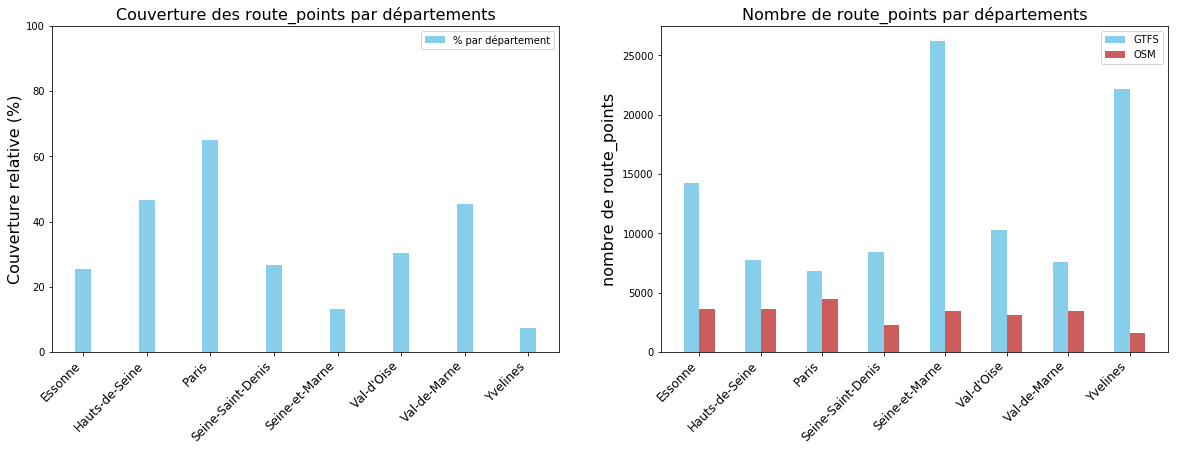

In [11]:
# histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig = plt.figure(figsize=(20, 6))
# 1er graph
ax = fig.add_subplot(121)
rects = ax.bar(ind, zones_with_routepoints_count["couverture_osm"], 
                width, color='SkyBlue', label='% par département')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 100)
ax.set_ylabel('Couverture relative (%)', fontsize=16)
ax.set_title('Couverture des route_points par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()

# 2eme graph
ax = fig.add_subplot(122)
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
rects1 = ax.bar(ind - width/2, zones_with_routepoints_count["nb_stops_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_routepoints_count["nb_stops_osm"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('nombre de route_points', fontsize=16)
ax.set_title('Nombre de route_points par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()




In [12]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_routepoints_count, data=zones_with_routepoints_count, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlGn', highlight=True)


m

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [13]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

24.68384209869312

In [78]:
#nombre moyen de terminus par ligne, pour OSM
osm_lines_and_routes = osm_routepoints[["osm_line_id","osm_route_id" ]].copy()
osm_lines_and_routes.drop_duplicates(inplace=True)
counts_routes_osm = osm_lines_and_routes.groupby('osm_line_id').size()
counts_routes_osm.mean()

1.9505928853754941

In [79]:
gtfs_lines_and_routes = gtfs_routepoints[["gtfs_route_id","gtfs_dest_name" ]].copy()
gtfs_lines_and_routes.drop_duplicates(inplace=True)
counts_routes_gtfs = gtfs_lines_and_routes.groupby('gtfs_route_id').size()
counts_routes_gtfs.mean()
#counts_routes_gtfs = counts_routes_gtfs.to_frame(name="nb_route").reset_index()

#counts_routes_gtfs[counts_routes_gtfs['nb_route'] == 18]
#counts_routes_gtfs[counts_routes_gtfs['gtfs_route_id'] == '100100057:57']
#gtfs_routepoints[gtfs_routepoints['gtfs_route_id'] == '100100057:57']


3.174061433447099

# Analyse quantitative par réseau

#### osm_routepoints

In [75]:
osm_routepoints_cleaned = osm_routepoints.copy()

osm_routepoints_cleaned.replace(to_replace="Navettes Aéroports De Paris", value="ADP", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Les Courriers de l'Île-de-France", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Keolis CIF", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Bus Val d'Oise", value="Busval d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Transdev CEAT", value="CEAT", inplace=True)
osm_routepoints_cleaned.replace(to_replace="La Navette Paris-Saclay", value="Paris-Saclay", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Réseau interurbain de Rambouillet", value="Rambouillet Interurbain", inplace=True)
osm_routepoints_cleaned.replace(to_replace="R'bus", value="rbus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Canton de Perthes en Gâtinais", value="Réseau du Canton de Perthes", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Seine-et-Marne Express", value="Seine et Marne Express", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Sénart Bus", value="Sénart-Bus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Tice", value="TICE", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYbus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYBUS", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SqyBus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="TransVO", value="Trans Val d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Still", value="STILL", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Î", value="I", inplace=True)



osm_networks = pd.DataFrame(osm_routepoints_cleaned.groupby('osm_network').size()).reset_index()
osm_networks.rename(columns={0: 'osm_routepoints_count'}, inplace=True)
osm_networks["osm_network_lower"] = osm_networks["osm_network"].str.lower()

gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
gtfs_agency_line_count = gtfs_routepoints.groupby('gtfs_agency_name').gtfs_route_short_name.nunique().reset_index()
gtfs_networks = gtfs_networks.merge(gtfs_agency_line_count, how='left', on='gtfs_agency_name')
gtfs_networks.rename(columns={0: 'gtfs_routepoints_count', "gtfs_route_short_name":"gtfs_lines_count"}, inplace=True)
gtfs_networks['gtfs_agency_name_lower'] = gtfs_networks['gtfs_agency_name'].str.lower()
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network_lower'], left_on=['gtfs_agency_name_lower'])
networks.drop('osm_network', axis=1, inplace=True)
networks.drop('osm_network_lower', axis=1, inplace=True)
networks.drop('gtfs_agency_name_lower', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_routepoints_count'] * 100.0 / networks['gtfs_routepoints_count']
#osm_routepoints_cleaned[osm_routepoints_cleaned["osm_network"].str.contains("Paris")]
#osm_routepoints_cleaned[osm_routepoints_cleaned['osm_network'].str.contains("ADP")]
networks

,gtfs_agency_name,gtfs_routepoints_count,gtfs_lines_count,osm_routepoints_count,osm_couverture
0,AUTOCARS DOMINIQUE,32,1,56,175.000000
1,Apolo 7,946,7,12,1.268499
2,Arlequin,1051,8,4,0.380590
3,Aérial,637,9,2,0.313972
4,Busval d'Oise,2345,32,823,35.095949
5,CEAT,7,2,116,1657.142857
6,CIF,3195,66,422,13.208138
7,Com'Bus,2113,30,4,0.189304
8,Conflans Achères,530,6,8,1.509434
9,Filéo,990,12,2,0.202020


### Top 10 des réseaux (les plus mappés et les moins mappés)

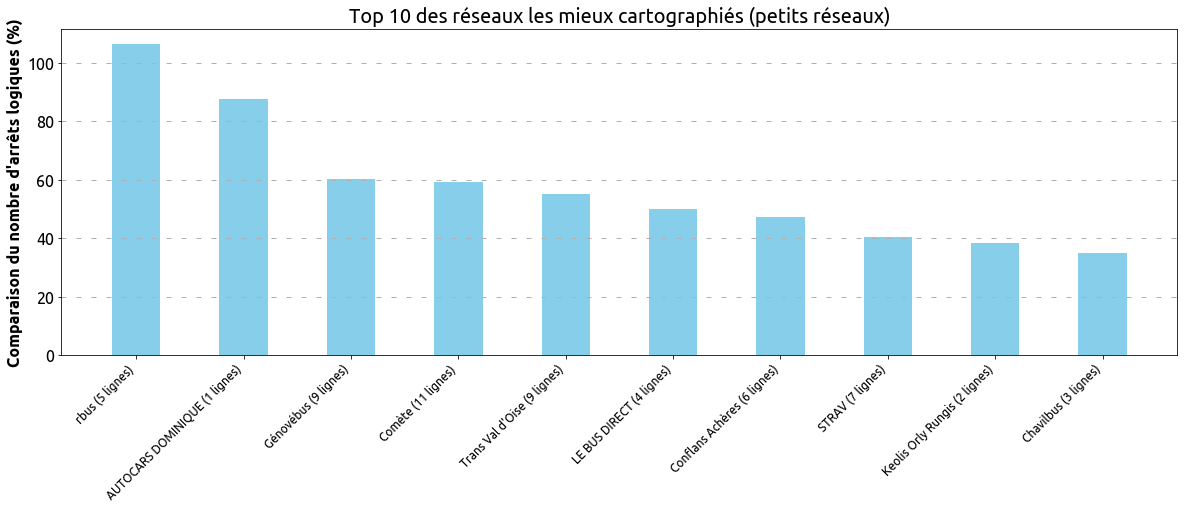

In [16]:
#networks_top_10 = networks.sort_values("osm_couverture", ascending=False).head(10)
networks_top_10 = networks[networks["gtfs_lines_count"] < 20].sort_values("osm_couverture", ascending=False).head(10)
networks_top_10["label"] = networks_top_10["gtfs_lines_count"].apply(str)
networks_top_10["label"] = networks_top_10["gtfs_agency_name"] + ' (' + \
    networks_top_10["label"].astype(str) + ' lignes)'

#networks_top_10

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks_top_10.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_top_10["osm_couverture"], 
                width, color='SkyBlue')
ax.set_ylabel('Comparaison du nombre d\'arrêts logiques (%)')
ax.set_title('Top 10 des réseaux les mieux cartographiés (petits réseaux)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_top_10["label"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)


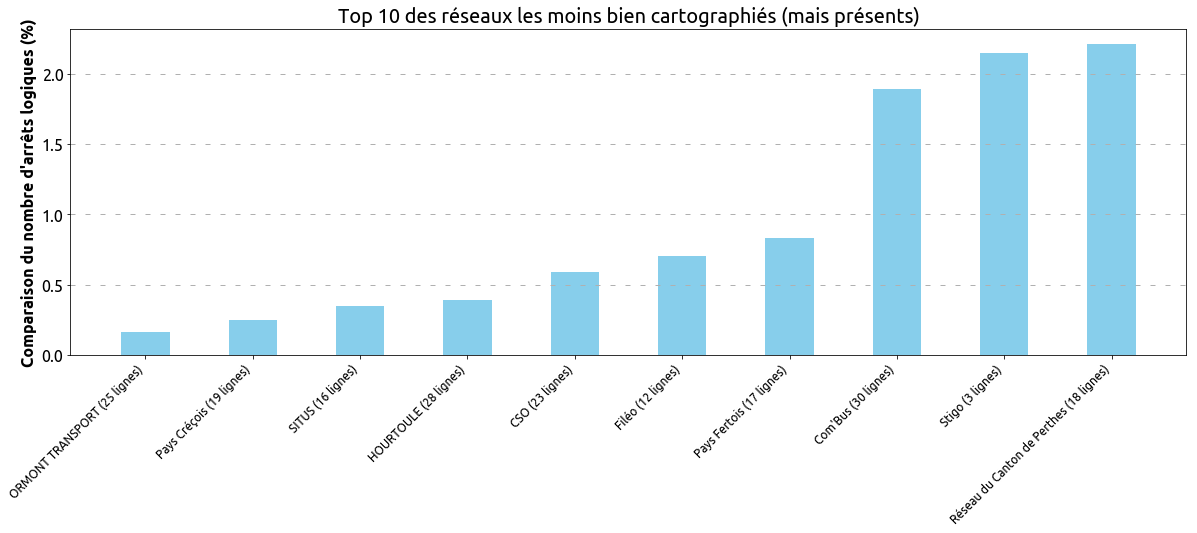

In [17]:
networks_flop_10 = networks.sort_values("osm_couverture", ascending=True).head(10)
networks_flop_10["label"] = networks_flop_10["gtfs_lines_count"].apply(str)
networks_flop_10["label"] = networks_flop_10["gtfs_agency_name"] + ' (' + \
    networks_flop_10["label"].astype(str) + ' lignes)'

#Le style du graphique est le même que le précédent :)
ind = np.arange(networks_top_10.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_flop_10["osm_couverture"], width, color='SkyBlue')
ax.set_ylabel('Comparaison du nombre d\'arrêts logiques (%)')
ax.set_title('Top 10 des réseaux les moins bien cartographiés (mais présents)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_flop_10["label"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)



### comparaisons par réseaux (à supprimer ?)

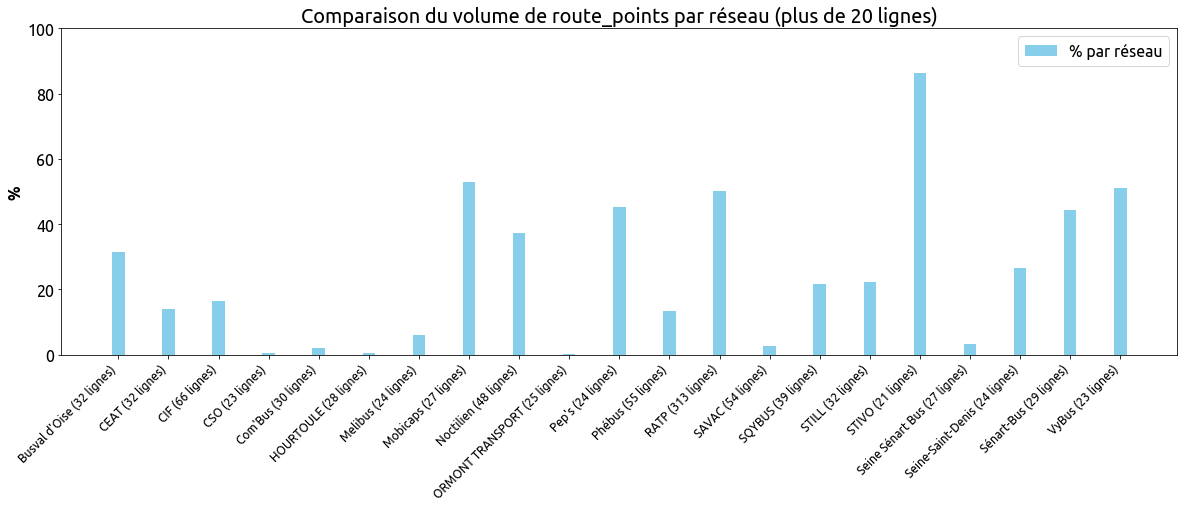

In [18]:
# Réseaux de plus de 20 lignes
networks_20lines_and_more = networks[networks["gtfs_lines_count"] >= 20].copy()
networks_20lines_and_more["label"] = networks_20lines_and_more["gtfs_lines_count"].apply(str)
networks_20lines_and_more["label"] = networks_20lines_and_more["gtfs_agency_name"] + ' (' + \
    networks_20lines_and_more["label"].astype(str) + ' lignes)'
width = 0.25  # the width of the bars
ind = np.arange(networks_20lines_and_more.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_20lines_and_more['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau (plus de 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_20lines_and_more["label"], rotation=45, ha='right')
ax.legend()


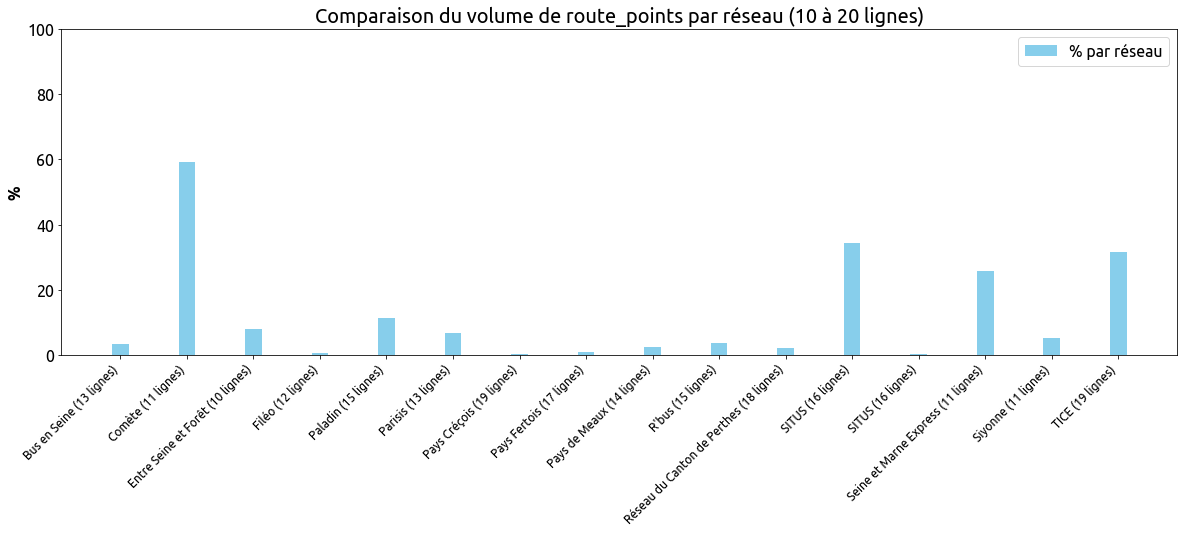

In [19]:
# Réseaux de moins de 20 lignes
networks_less_than_20lines = networks[(networks["gtfs_lines_count"] < 20) & (networks["gtfs_lines_count"] >= 10)].copy()
networks_less_than_20lines["label"] = networks_less_than_20lines["gtfs_lines_count"].apply(str)
networks_less_than_20lines["label"] = networks_less_than_20lines["gtfs_agency_name"] + ' (' + \
    networks_less_than_20lines["label"].astype(str) + ' lignes)'
width = 0.25  # the width of the bars
ind = np.arange(networks_less_than_20lines.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_less_than_20lines['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau (10 à 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_less_than_20lines["label"], rotation=45, ha='right')
ax.legend()

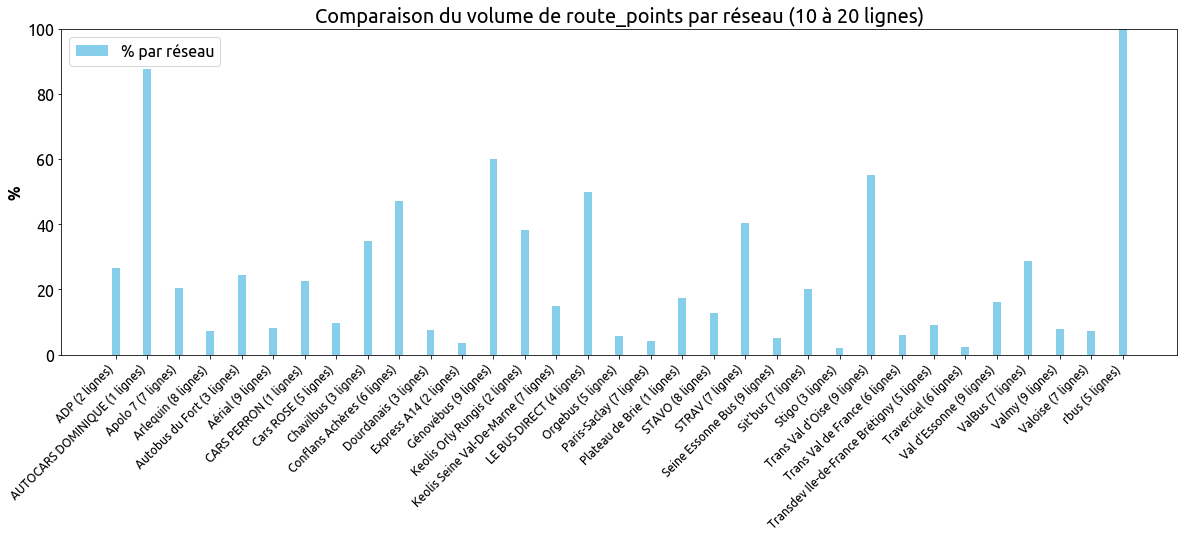

In [20]:
# Réseaux de moins de 10 lignes
networks_less_than_10lines = networks[networks["gtfs_lines_count"] < 10].copy()
networks_less_than_10lines["label"] = networks_less_than_10lines["gtfs_lines_count"].apply(str)
networks_less_than_10lines["label"] = networks_less_than_10lines["gtfs_agency_name"] + ' (' + \
    networks_less_than_10lines["label"].astype(str) + ' lignes)'
width = 0.25  # the width of the bars
ind = np.arange(networks_less_than_10lines.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_less_than_10lines['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau (10 à 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_less_than_10lines["label"], rotation=45, ha='right')
ax.legend()

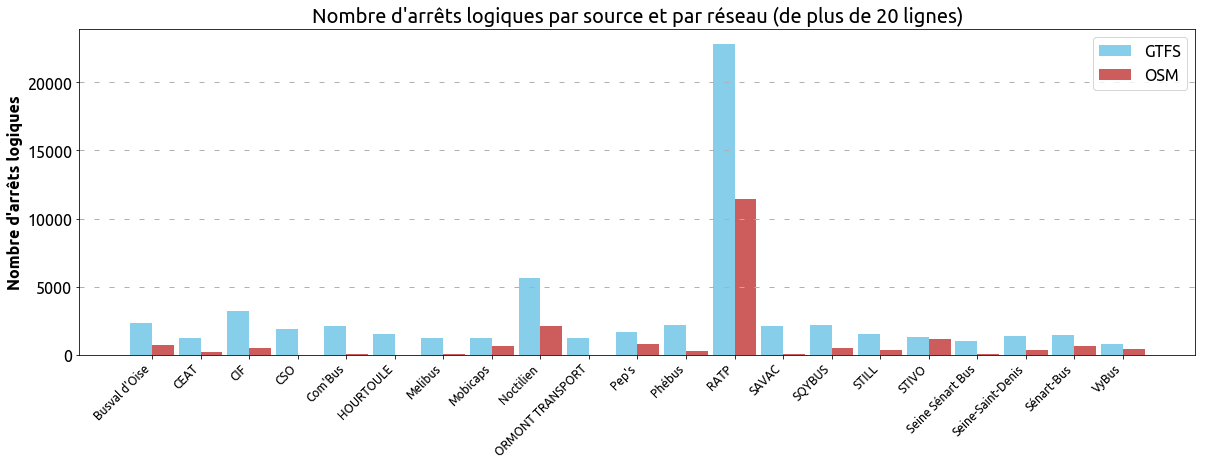

In [21]:
# la première ligne fait un reset du style 
mpl.rcParams.update(inline_rc)
# plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks_20lines_and_more.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects1 = ax.bar(ind - width/2, networks_20lines_and_more["gtfs_routepoints_count"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, networks_20lines_and_more["osm_routepoints_count"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('Nombre d\'arrêts logiques')
ax.set_title('Nombre d\'arrêts logiques par source et par réseau (de plus de 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_20lines_and_more["gtfs_agency_name"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)

ax.legend()

# Analyse qualitative

uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

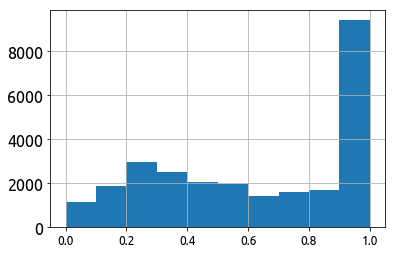

In [22]:
osm_routepoints = pd.read_csv("../data/osm_routepoints_for_matching.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints.fillna("", inplace=True)
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
routepoints.fillna("", inplace=True)

def compute_similarity_for_terminus(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_for_terminus(*x), axis=1)
routepoints['destination_confidence'].hist()

In [23]:
routepoints = routepoints[routepoints['destination_confidence'] >= 0.6]

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [24]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

## Mesures qualitatives

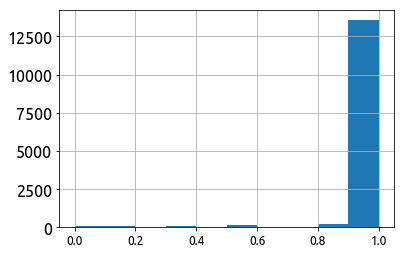

In [25]:
# différences sur les codes de ligne
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()

In [26]:
routepoints_ = routepoints[routepoints['line_code_confidence'] < 0.8]
routepoints_ = routepoints_[['gtfs_route_short_name', 'osm_code']]
grouped = routepoints_.groupby(['gtfs_route_short_name', 'osm_code'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df

,gtfs_route_short_name,osm_code
10300,MONTMAR,Montmartrobus
21238,BIEVRES,513
9414,FA-LYCEE,FA Lycée
21228,CHARONN,501
19928,ORLYBUS,Orlybus
0,CEN,Centaure
9516,Tzen1,TZen 1
21248,NAVETTE,524
21250,MONTBUS,526
21286,V1,v1


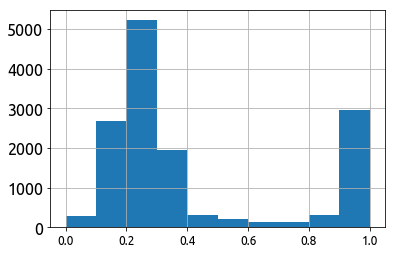

In [27]:
# différences sur les noms des arrêts
routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()

In [28]:
routepoints_ = routepoints[routepoints['name_confidence'] < 0.5]
routepoints_ = routepoints_[['gtfs_stop_name', 'osm_name']]
grouped = routepoints_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df.head()

,gtfs_stop_name,osm_name
3054,ALLEE DU CHATEAU,Allée du Château
21262,VANNE,Vanne
20888,GEORGES POMPIDOU,Georges Pompidou
16945,ALLEE DE LA TOUR,Allée de la Tour
4275,LES GENETS,Les Genêts


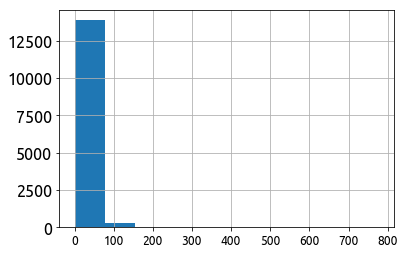

In [29]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()
#TODO : trouver une meilleure représentation graphique qui montre que 
#l'essentiel est en dessous de 50 m, mais qu'il y a des points bien bien loin
# ptet une boite à moustache ?

In [30]:
routepoints['distance'].mean()

17.989192817822264

In [31]:
routepoints_ = routepoints[routepoints['distance'] > 80]
len(routepoints_)

350

In [32]:
routepoints_ = routepoints_.sort_values(by='distance') 
#TODO : trouver un moyen sympa de visualiser ces écarts de distance
routepoints_

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_name,osm_lat,osm_lon,osm_route_id,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_osm:ref:FR:STIF,destination_confidence,line_code_confidence,name_confidence,distance
18435,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,Cousin de Méricourt,48.797711799999995,2.3332596,Route:Relation:1991745,100100162:162,28582,0.800000,1.000000,0.210526,80.228791
18434,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,Cousin de Méricourt,48.797711799999995,2.3332596,Route:Relation:1991745,100100162:162,28582,0.800000,1.000000,0.210526,80.228791
18763,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,Cousin de Méricourt,48.797711799999995,2.3332596,Route:Relation:1259521,100100184:184,28582,0.636364,1.000000,0.210526,80.228791
18762,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,Cousin de Méricourt,48.797711799999995,2.3332596,Route:Relation:1259521,100100184:184,28582,0.636364,1.000000,0.210526,80.228791
21605,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,Brochant - Cardinet,48.891836,2.3179000999999997,Route:Relation:1553500,100987753:N51,24603,0.971429,1.000000,0.263158,80.289990
23545,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,Brochant - Cardinet,48.891836,2.3179000999999997,Route:Relation:1537047,100987782:N15,24603,0.851852,1.000000,0.263158,80.289990
14368,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PLACE DE CLICHY,74,RATP,...,Brochant - Cardinet,48.891836,2.3179000999999997,Route:Relation:7925363,100100074:74,24603,1.000000,1.000000,0.263158,80.289990
14375,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,Brochant - Cardinet,48.891836,2.3179000999999997,Route:Relation:1253892,100100074:74,24603,0.928571,1.000000,0.263158,80.289990
21606,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,Brochant - Cardinet,48.891836,2.3179000999999997,Route:Relation:1553500,100987753:N51,24603,0.971429,1.000000,0.263158,80.289990
14374,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,Brochant - Cardinet,48.891836,2.3179000999999997,Route:Relation:1253892,100100074:74,24603,0.928571,1.000000,0.263158,80.289990
